<a href="https://colab.research.google.com/github/D-314/cyber-tuber/blob/main/processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
!git clone https://github.com/D-314/cyber-tuber.git
!mv cyber-tuber/* .
!rm -rf cyber-tuber

Cloning into 'cyber-tuber'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 31 (delta 14), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (31/31), 76.72 KiB | 2.84 MiB/s, done.


In [98]:
dataset = pd.read_csv("baza_dannykh_dlya_stati.csv").set_index('№')

In [99]:
# Функция для поиска последней ячейки с единицей в строке (написанная силами ChatGPT :))
def find_last_one(df_row):
    """
    Функция находит последнюю ячейку со значением 1 в переданной строке DataFrame и возвращает имя колонки для этой ячейки.
    Если вся строка состоит из NaN, возвращает пустую строку.
    """
    last_one = None
    for col in df_row.index[::-1]:
        if df_row[col] == 1:
            last_one = col
            break
    return last_one if last_one is not None else np.NaN

In [100]:
in_city = dataset['Житель Омска'].astype(str).apply(lambda x: 'Область' if (x[0] == '0') else 'Город' if (x[0] == '1') else np.NAN)
region = dataset['Житель Омска'].astype(str)+dataset['Житель ОО'].astype(str)
region = region.str.extract(r'\((.*?)\)')
graduation = dataset[['Образование среднее не полное','Среднее полное','Средне-специальное','Высшее']].apply(find_last_one, axis=1)
graduation = graduation.replace({'Образование среднее не полное': 'Ср.неполное',
                                 'Средне-специальное': 'Ср.специальное',
                                 'Среднее полное': 'Ср.полное',})
work = dataset[['Работает\Учащийся','Безработный','Пенсионер']].apply(find_last_one, axis=1)
df = pd.concat([in_city, region,work,graduation], axis=1)
del in_city, region,graduation,work
df.columns = ['Локация', 'Регион', 'Работа' , 'Образование']
df

,Локация,Регион,Работа,Образование
№,,,,
ОСК111,Область,Крутинский,Работает\Учащийся,Ср.специальное
ОСК112,Область,Крутинский,Безработный,Ср.полное
ОСК113,Область,Усть-Ишимский,Безработный,Ср.специальное
ОСК114,Город,ЛАО,Работает\Учащийся,Ср.специальное
ОСК115,Область,Муромцевский,Работает\Учащийся,Ср.полное
...,...,...,...,...
ОСК183,Город,КАО,Безработный,Ср.специальное
ОСК184,Город,ЛАО,NaN,Ср.неполное
ОСК185,Область,Исилькульский,Пенсионер,Ср.специальное


<Axes: xlabel='Локация'>

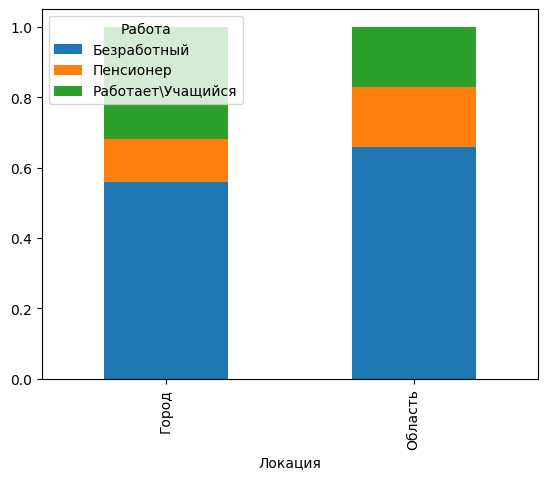

In [101]:
# группируем по первому столбцу и считаем частоту появления значений во втором столбце
counts = df.groupby('Локация')['Работа'].value_counts(normalize=True)

# строим график
counts.unstack().plot(kind='bar', stacked=True)